In [37]:
import pandas as pd
import json
import os

# Load your prediction results
df_preds = pd.read_csv("/home/hadeel/MAMA-MIA_Challenge/machine_learning/outputs/validation_predictions.csv")

# Folder with JSON clinical info
json_folder = "/data/MAMA-MIA/patient_info_files/"

# Collect clinical data
records = []

for idx, row in df_preds.iterrows():
    patient_id = row["patient_id"]
    json_path = os.path.join(json_folder, f"{patient_id}.json")
    
    if not os.path.exists(json_path):
        print(f"⚠️ Missing JSON for {patient_id}")
        continue
    
    with open(json_path, "r") as f:
        data = json.load(f)

    age = data["clinical_data"].get("age", None)
    menopausal_status = data["clinical_data"].get("menopausal_status", "").lower()
    if "peri" in menopausal_status or "pre" in menopausal_status:
        menopausal_status = "pre"
    elif "post" in menopausal_status:
        menopausal_status = "post"
    else:
        menopausal_status = "unknown"

    breast_density = data["clinical_data"].get("breast_density", "")
    if breast_density == "":
        breast_density = "unknown"

    # True PCR label from JSON
    pcr = data["primary_lesion"]["pcr"]

    records.append({
        "patient_id": patient_id,
        "pcr": pcr,
        "pcr_pred": int(row["pred_label"]),
        "age": age,
        "menopausal_status": menopausal_status,
        "breast_density": breast_density
    })

# Create full DataFrame
fairness_df = pd.DataFrame(records)

# Bin age into groups
fairness_df["age"] = pd.cut(
    fairness_df["age"],
    bins=[0, 40, 50, 60, 70, 100],
    labels=["0-40", "41-50", "51-60", "61-70", "71+"]
)

# Save final CSV to use with scoring script
fairness_df.to_csv("/home/hadeel/MAMA-MIA_Challenge/machine_learning/outputs/results_task2.csv", index=False)

Average Balanced Accuracy: 0.5420
Fairness Score: 0.0874
Ranking Score: 0.3147

Subgroup metrics by age
  0-40: Balanced Acc = 0.507, AUC = 0.507 (Samples: 77)
  41-50: Balanced Acc = 0.584, AUC = 0.584 (Samples: 120)
  51-60: Balanced Acc = 0.532, AUC = 0.532 (Samples: 78)
  61-70: Balanced Acc = 0.525, AUC = 0.525 (Samples: 24)
  71+: Balanced Acc = 0.375, AUC = 0.375 (Samples: 6)

Subgroup metrics by menopausal_status
  post: Balanced Acc = 0.521, AUC = 0.521 (Samples: 62)
  pre: Balanced Acc = 0.513, AUC = 0.513 (Samples: 130)
  unknown: Balanced Acc = 0.584, AUC = 0.584 (Samples: 114)

Subgroup metrics by breast_density
  a: Balanced Acc = 0.000, AUC = nan (Samples: 1)
  b: Balanced Acc = 0.000, AUC = 0.000 (Samples: 3)
  c: Balanced Acc = 1.000, AUC = 1.000 (Samples: 7)
  d: Balanced Acc = 1.000, AUC = 1.000 (Samples: 4)
  unknown: Balanced Acc = 0.533, AUC = 0.533 (Samples: 291)


/home/hadeel/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/hadeel/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


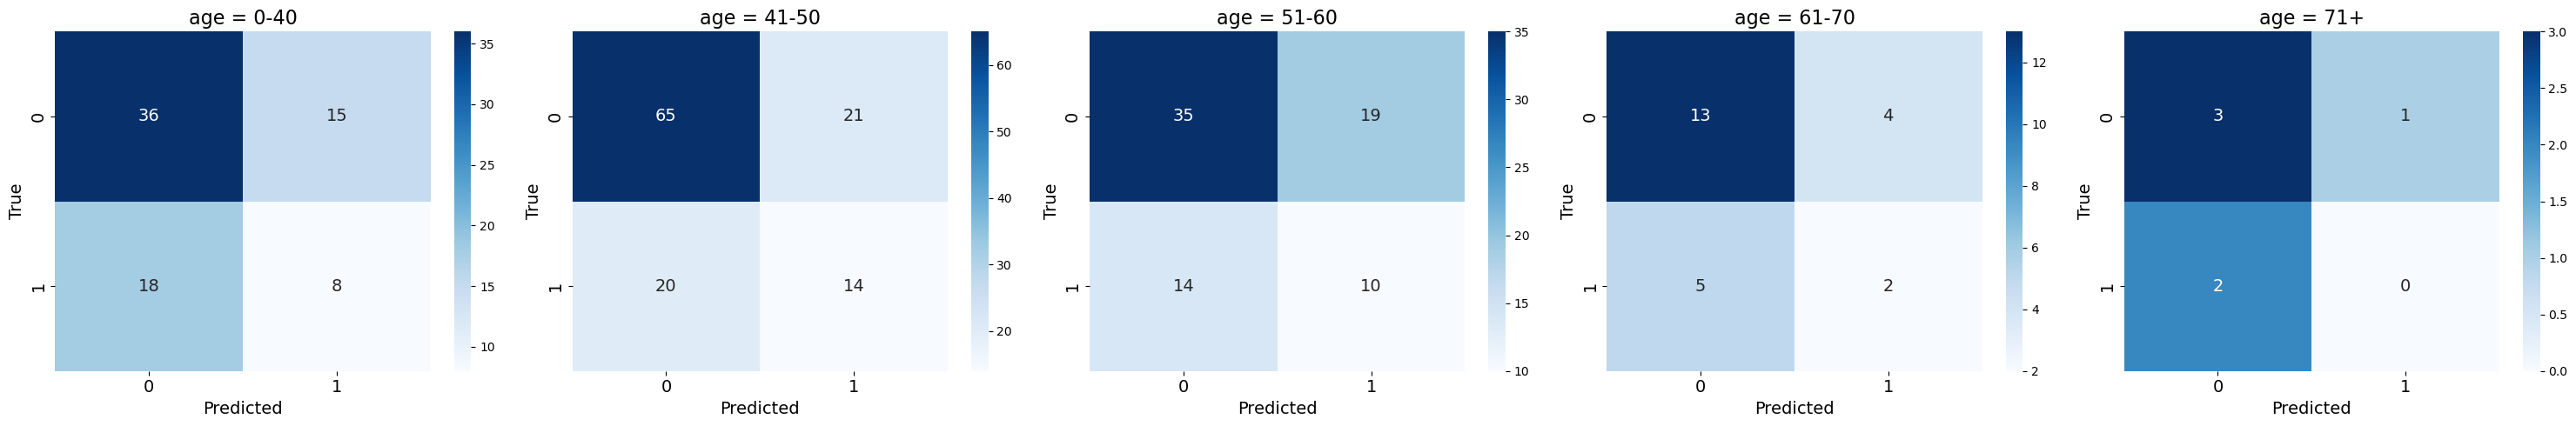

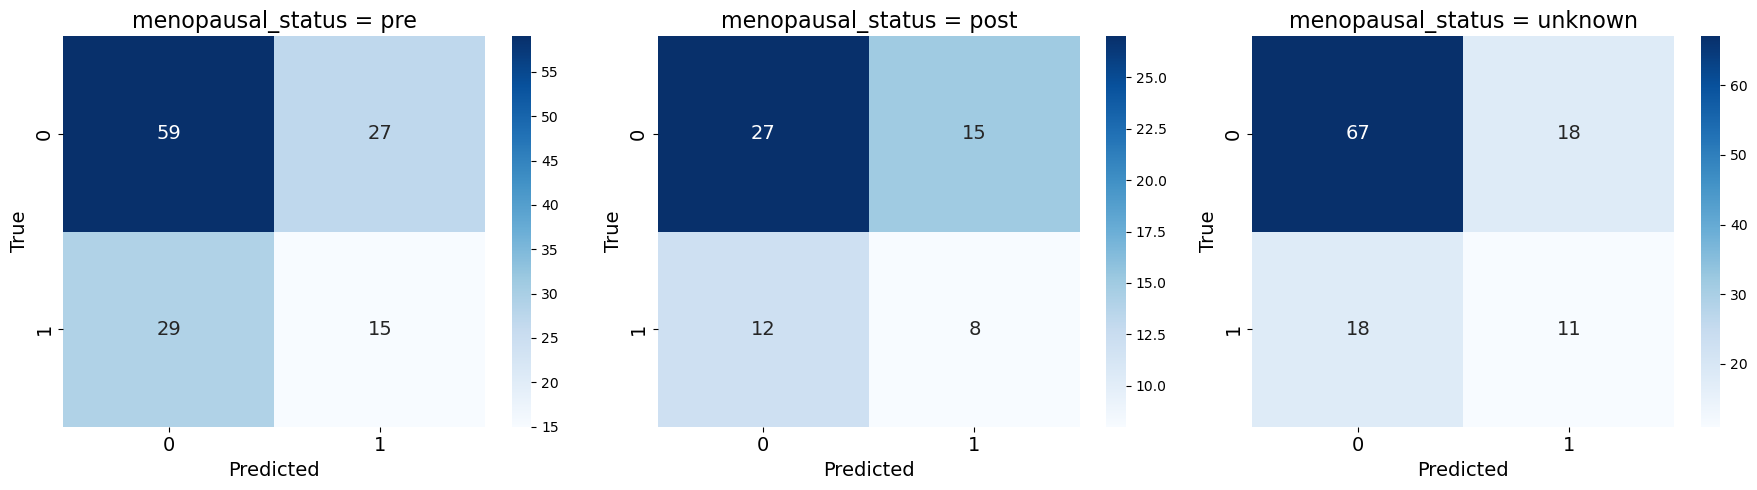

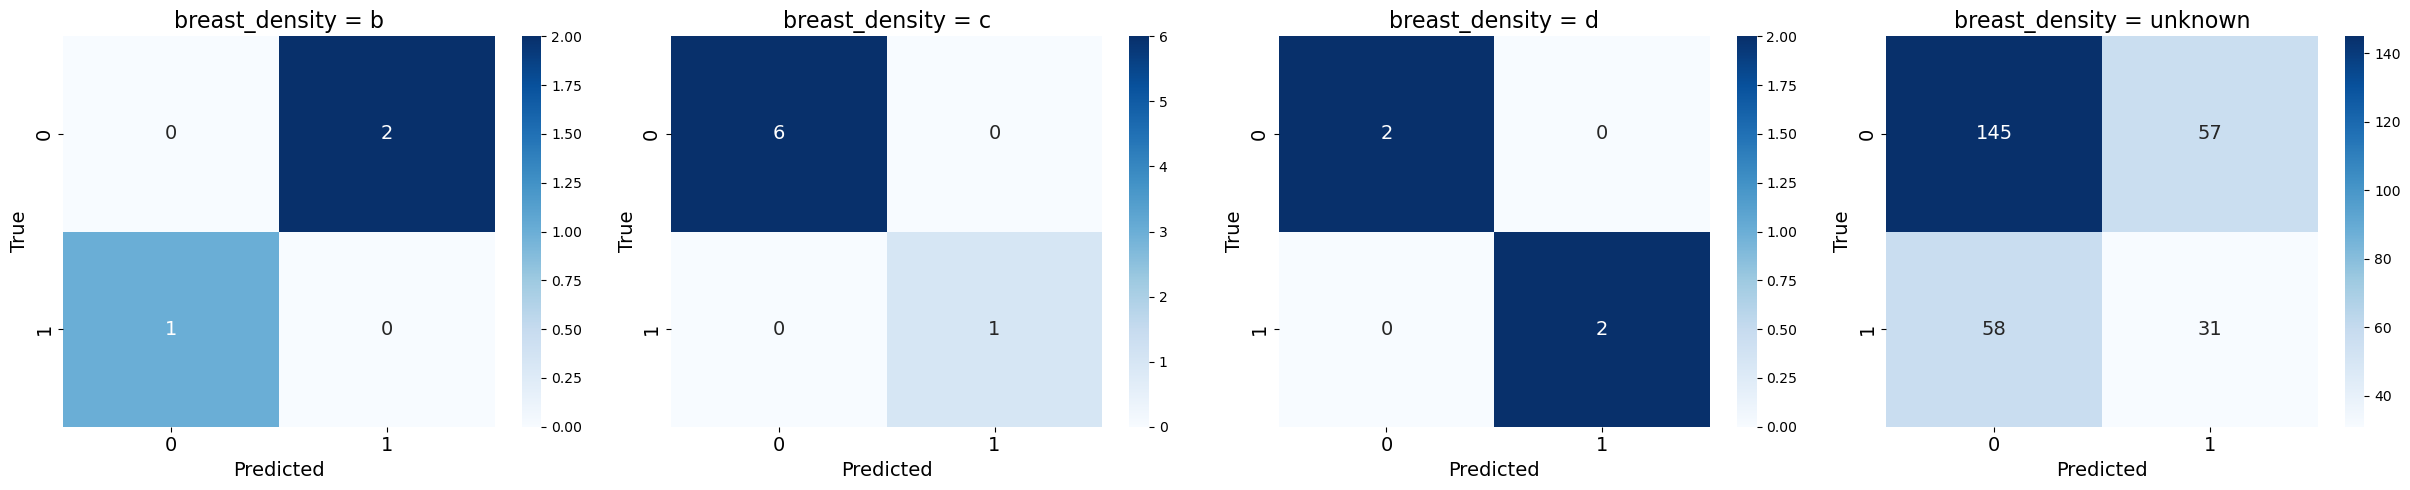

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score

# ----------------------------
# Utility Functions
# ----------------------------

def plot_confusion_matrices(df, group_var, y_true_col='pcr', y_pred_col='pcr_pred', save_path=None):
    groups = df[group_var].dropna().unique()
    num_groups = len(groups)
    cols = num_groups
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    if group_var == 'age':
        age_order = ['0-40', '41-50', '51-60', '61-70', '71+']
        groups = sorted(groups, key=lambda x: age_order.index(x) if x in age_order else len(age_order))
    elif group_var == 'breast_density':
        density_order = ['a', 'b', 'c', 'd', 'unknown']
        groups = sorted(groups, key=lambda x: density_order.index(x) if x in density_order else len(density_order))
    elif group_var == 'menopausal_status':
        menopause_order = ['pre', 'post', 'unknown']
        groups = sorted(groups, key=lambda x: menopause_order.index(x) if x in menopause_order else len(menopause_order))

    for i, group in enumerate(groups):
        subset = df[df[group_var] == group]
        y_true = subset[y_true_col].astype(int)
        y_pred = subset[y_pred_col].astype(int)
        if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
            axes[i].set_visible(False)
            continue
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={"size": 14})
        axes[i].set_title(f'{group_var} = {group}', fontsize=16)
        axes[i].set_xlabel('Predicted', fontsize=14)
        axes[i].set_ylabel('True', fontsize=14)
        axes[i].tick_params(axis='both', labelsize=14)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_fairness_radar(equalized_odds_disparities, output_path):
    variables = list(equalized_odds_disparities.keys())
    disparities = list(equalized_odds_disparities.values())

    angles = np.linspace(0, 2 * np.pi, len(variables), endpoint=False).tolist()
    disparities += disparities[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, disparities, 'o-', linewidth=2, label='Equalized Odds Disparity')
    ax.fill(angles, disparities, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), variables)
    ax.set_title('Fairness Disparity (TPR+FPR)')
    ax.set_ylim(0, max(disparities) + 0.1)
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def print_subgroup_metrics(df, fairness_variables):
    for var in fairness_variables:
        print(f'\nSubgroup metrics by {var}')
        for group_name, group in df.groupby(var):
            y_true = group['pcr'].astype(int)
            y_pred = group['pcr_pred'].astype(int)
            try:
                bacc = balanced_accuracy_score(y_true, y_pred)
                auc = roc_auc_score(y_true, group['pcr_pred'])
                print(f'  {group_name}: Balanced Acc = {bacc:.3f}, AUC = {auc:.3f} (Samples: {len(group)})')
            except ValueError:
                print(f'  {group_name}: Not enough samples for AUC')

# ----------------------------
# Main Execution
# ----------------------------

if __name__ == '__main__':

    alpha = 0.5
    selected_fairness_variables = ['age', 'menopausal_status', 'breast_density']

    # Use the prepared CSV file
    output_csv = "/home/hadeel/MAMA-MIA_Challenge/machine_learning/outputs/results_task2.csv"
    output_plots_dir = "/home/hadeel/MAMA-MIA_Challenge/machine_learning/outputs/plots"
    os.makedirs(output_plots_dir, exist_ok=True)

    # Read the CSV file with predictions + clinical info
    df = pd.read_csv(output_csv)

    # Convert any missing predictions or labels to 0
    df['pcr'] = df['pcr'].fillna(0).astype(int)
    df['pcr_pred'] = df['pcr_pred'].fillna(0).astype(int)

    # Compute performance
    balanced_accuracy = balanced_accuracy_score(df['pcr'], df['pcr_pred'])
    print(f'Average Balanced Accuracy: {balanced_accuracy:.4f}')
    performance_score = balanced_accuracy

    # Fairness scoring
    equalized_odds_disparities = {}
    for var in selected_fairness_variables:
        groups = df.groupby(var)
        tpr, fpr = {}, {}
        for i, (_, group) in enumerate(groups):
            yt = group['pcr'].astype(int)
            yp = group['pcr_pred'].astype(int)
            try:
                tn, fp_, fn, tp = confusion_matrix(yt, yp).ravel()
                tpr[i] = tp / (tp + fn) if (tp + fn) else 0
                fpr[i] = fp_ / (fp_ + tn) if (fp_ + tn) else 0
            except ValueError:
                tpr[i], fpr[i] = 0, 0

        disparity = max(tpr.values()) - min(tpr.values()) + max(fpr.values()) - min(fpr.values())
        equalized_odds_disparities[var] = disparity

    fairness_score = np.clip(np.mean(list(equalized_odds_disparities.values())), 0, 1)
    ranking_score = (1 - alpha) * performance_score + alpha * (1 - fairness_score)

    print(f'Fairness Score: {1 - fairness_score:.4f}')
    print(f'Ranking Score: {ranking_score:.4f}')

    # Print subgroup metrics
    print_subgroup_metrics(df, selected_fairness_variables)

    # Plots
    radar_plot_path = os.path.join(output_plots_dir, 'radar_fairness_disparities.png')
    plot_fairness_radar(equalized_odds_disparities, radar_plot_path)

    for var in selected_fairness_variables:
        plot_confusion_matrices(
            df, group_var=var,
            save_path=os.path.join(output_plots_dir, f'cm_by_{var}.png')
        )